In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
LAG = 12
EPS = 60
SIND = 30
DEEP = False
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [4]:
dset = SingleStop(SROUTE, SIND, 'train', 32, lag=LAG).generator()
evalset = SingleStop(SROUTE, SIND, 'test', 32, lag=LAG).generator()

Locals dataset: train
 [*] Loaded routes: 1 (0.32s)
 [*] Has trainable inds: 262262
 [*] Subset train: 212106
 [*] Subset in Stop-30: 6079
Locals dataset: test
 [*] Loaded routes: 1 (0.31s)
 [*] Has trainable inds: 262262
 [*] Subset test: 50156
 [*] Subset in Stop-30: 1549


In [5]:
yavg = SingleStop(SROUTE, SIND, 'train', 32, lag=LAG).yavg()
print('Y-avg:', yavg)

Locals dataset: train
 [*] Loaded routes: 1 (0.32s)
 [*] Has trainable inds: 262262
 [*] Subset train: 212106
 [*] Subset in Stop-30: 6079
Y-avg: 3.4391126863581287


In [6]:
from models.temporal.RNN_0 import RNN_0

In [8]:
model = RNN_0(hidden_size=256, deep=DEEP, lag=LAG).to(device)
model.device = device

In [9]:
criterion, opt, sch = model.params(lr=0.001)

In [12]:
evaluate(evalset, model, crit=lambda _y, y: wape(tonpy(_y), tonpy(y), yavg))
evaluate(evalset, model, crit=lambda _y, y: criterion(_y, y).item())

Eval loss: 104.5027   
Eval loss: 18.8299   


In [13]:
losses = []
eval_mse = []
eval_mape = []
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    eval_mse.append(
        evaluate(evalset, model, crit=lambda _y, y: criterion(_y, y).item(), result=True))
    eval_mape.append(
        evaluate(evalset, model, 
                 crit=lambda _y, y: wape(tonpy(_y), tonpy(y), yavg), result=True))
    sys.stdout.flush()
#     sch.step()

[1/60 : 189/189] - L0.22       
Eval loss: 1.8842    
Eval loss: 13.1090   
[2/60 : 189/189] - L0.12       
Eval loss: 1.3328    
Eval loss: 8.2676    
[3/60 : 189/189] - L0.06       
Eval loss: 1.0887    
Eval loss: 6.6038    
[4/60 : 189/189] - L0.02       
Eval loss: 0.9430    
Eval loss: 4.8053    
[5/60 : 189/189] - L0.01       
Eval loss: 0.8279    
Eval loss: 4.2248    
[6/60 : 189/189] - L0.03       
Eval loss: 0.7414    
Eval loss: 3.9436    
[7/60 : 189/189] - L0.02       
Eval loss: 0.6740   
Eval loss: 3.8064    
[8/60 : 189/189] - L0.22       
Eval loss: 0.6768    
Eval loss: 7.6239    
[9/60 : 189/189] - L0.01       
Eval loss: 0.5594    
Eval loss: 3.0791    
[10/60 : 189/189] - L0.03       
Eval loss: 0.5168    
Eval loss: 3.1182    
[11/60 : 189/189] - L0.01       
Eval loss: 0.4780    
Eval loss: 2.8205    
[12/60 : 189/189] - L0.01       
Eval loss: 0.4465   
Eval loss: 2.6398    
[13/60 : 189/189] - L0.01       
Eval loss: 0.4134   
Eval loss: 2.5411    
[14/60 : 18

Process Process-769:
Process Process-770:


Process Process-771:
Process Process-774:
Process Process-772:
Process Process-773:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    sel

In [18]:
# name = 'n10-%s-%d'% (SROUTE, SIND)
# torch.save(model.state_dict(), 'checkpoints/rnn/%s.pth' % name)

In [19]:
# with open('checkpoints/rnn/%s.json' % name, 'w') as fl:
#     json.dump(dict(
#         mse=eval_mse,
#         mape=eval_mape,
#     ), fl, indent=4)

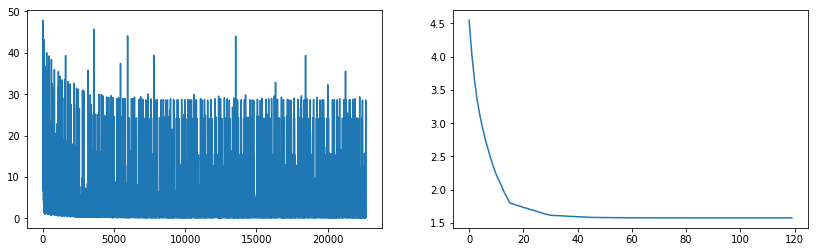

In [14]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.subplot(1, 2, 2)
plt.plot(eval_mse)
plt.show();plt.close()

In [ ]:
data = history_byname(SROUTE)

sample = data[int(TSTEPS*0.8):]
inds, integs = high_integ(sample[LAG:])
inds += LAG
# print(inds[0])
print('Visualize period', inds[0])
sample = sample[inds[0]-LAG:inds[0]]
# sample = hist_smooth(sample)
print(np.count_nonzero(np.isnan(sample)))
for jj, ii in zip(*np.where(np.isnan(sample))):
    sample[jj, ii] = sample[jj-1, ii]
show_context(sample)

In [ ]:
bi = 30
hist = torch.Tensor(np.expand_dims(sample[:, bi-10:bi], 0))
Xs, _ = model.format_batch(hist)
yout = tonpy(model(Xs))
print(yout.shape)
#     preds.append(tonpy(yout))

In [ ]:
l = show_context(sample, draw=False)
ylast = np.flip(yout[0, :])
xpos = list(range(bi-10, bi))
# plt.plot([25, 25], [-5, 1], color='#666666')
# plt.plot([25, 25], [9, 7], color='#666666')
p = plt.plot(xpos, ylast, color='C1')
plt.xlim(19, 31)
plt.ylim(0, 8)
plt.legend([l[0], p[0]], ['Known Travel Speed', 'Predicted Travel Speed'])
plt.show(); plt.close()